In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_apart=pd.read_csv('../../Dataset_Apart/Cleaned/DatasetAirbnb_Cleaned_v1.csv')
data_apart.head()

,ID,Titulo,Descripcion Simple,Evaluaciones,Tipo,Precio,URL,Limpieza,Veracidad,Llegada,...,Localizacion,Capacidad,Camas,Baños,Dormitorios,Baño Compartido,Wifi,Mascotas,Piscina,Parking
0,1200688382914319681,Magníficas vistas sobre la arena de la playa Wifi,Alojamiento entero: piso en Guardamar de la Sa...,59.0,A pie de playa,78.0,https://www.airbnb.es/rooms/31709557?adults=1&...,4.9,4.9,5.0,...,"Guardamar de la Safor, Comunidad Valenciana, E...",6.0,5.0,2.0,3.0,0,1.0,1.0,1.0,1.0
1,5375220911806434689,Melior-1E,"Alojamiento entero: piso en Calp, España",8.0,A pie de playa,83.0,https://www.airbnb.es/rooms/37584336?adults=1&...,4.9,4.5,4.5,...,"Calp, España",6.0,3.0,2.0,2.0,0,1.0,0.0,0.0,0.0
2,556517738340669403,VERALUX,"Alojamiento entero: piso en Benidorm, España",20.0,A pie de playa,70.0,https://www.airbnb.es/rooms/46527977?adults=1&...,3.5,4.6,4.7,...,"Benidorm, Comunidad Valenciana, España",4.0,3.0,2.0,2.0,0,1.0,1.0,1.0,0.0
3,8800182335332003755,Isea Calpe,"Alojamiento entero: piso en Calp, España",557.0,A pie de playa,128.0,https://www.airbnb.es/rooms/721277134871448378...,NaN,NaN,NaN,...,"Calp, Comunidad Valenciana, España",4.0,3.0,2.0,2.0,0,1.0,0.0,1.0,0.0
4,-5036294419472545696,"Apartamento luminoso, internet, Netflix",Alojamiento entero: apto. residencial en Grau ...,64.0,A pie de playa,85.0,https://www.airbnb.es/rooms/50155790?adults=1&...,4.9,4.9,4.9,...,"Grau i Platja, Comunidad Valenciana, España",6.0,6.0,1.0,2.0,0,1.0,0.0,1.0,1.0


In [3]:
data_apart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788 entries, 0 to 787
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  788 non-null    int64  
 1   Titulo              788 non-null    object 
 2   Descripcion Simple  788 non-null    object 
 3   Evaluaciones        771 non-null    float64
 4   Tipo                788 non-null    object 
 5   Precio              788 non-null    float64
 6   URL                 788 non-null    object 
 7   Limpieza            719 non-null    float64
 8   Veracidad           719 non-null    float64
 9   Llegada             719 non-null    float64
 10  Comunicacion        719 non-null    float64
 11  Ubicacion           719 non-null    float64
 12  Calidad             719 non-null    float64
 13  Localizacion        784 non-null    object 
 14  Capacidad           726 non-null    float64
 15  Camas               763 non-null    float64
 16  Baños   

# **Comprobamos valores nulos**
---

In [4]:
data_apart.isna().sum()

ID                     0
Titulo                 0
Descripcion Simple     0
Evaluaciones          17
Tipo                   0
Precio                 0
URL                    0
Limpieza              69
Veracidad             69
Llegada               69
Comunicacion          69
Ubicacion             69
Calidad               69
Localizacion           4
Capacidad             62
Camas                 25
Baños                 61
Dormitorios           77
Baño Compartido        0
Wifi                   4
Mascotas               4
Piscina                4
Parking                4
dtype: int64

# **Descripcion de las variables numéricas**
---

In [5]:
data_apart.describe()

,ID,Evaluaciones,Precio,Limpieza,Veracidad,Llegada,Comunicacion,Ubicacion,Calidad,Capacidad,Camas,Baños,Dormitorios,Baño Compartido,Wifi,Mascotas,Piscina,Parking
count,7.880000e+02,771.000000,788.000000,719.000000,719.000000,719.000000,719.000000,719.000000,719.000000,726.000000,763.000000,727.000000,711.000000,788.000000,784.000000,784.000000,784.000000,784.000000
mean,1.997703e+17,90.084306,151.396995,4.731154,4.814743,4.840890,4.867316,4.828095,4.685535,5.619835,3.787680,2.033012,2.465541,0.045685,0.806122,0.428571,0.437500,0.871173
std,5.433749e+18,279.176394,135.834429,0.282059,0.214397,0.195057,0.204755,0.171883,0.243722,3.304558,2.832971,1.520841,1.459744,0.208934,0.395586,0.495188,0.496395,0.335222
min,-9.203792e+18,1.000000,0.000000,2.800000,2.700000,3.200000,3.000000,3.300000,3.300000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-4.758058e+18,15.000000,75.000000,4.600000,4.800000,4.800000,4.800000,4.800000,4.600000,4.000000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,4.143693e+17,40.000000,110.000000,4.800000,4.900000,4.900000,4.900000,4.900000,4.700000,5.000000,3.000000,1.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,4.943199e+18,98.500000,180.000000,4.900000,5.000000,5.000000,5.000000,4.900000,4.800000,6.000000,5.000000,2.000000,3.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,9.198468e+18,6854.000000,1270.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,16.000000,22.000000,8.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# **Descripcion de las variables categóricas**
---

In [6]:
data_apart.describe(include='O')

,Titulo,Descripcion Simple,Tipo,URL,Localizacion
count,788,788,788,788,784
unique,785,537,3,788,408
top,Isea Calpe,"Alojamiento entero: piso en Benidorm, España",En el campo,https://www.airbnb.es/rooms/31709557?adults=1&...,"Benidorm, Comunidad Valenciana, España"
freq,2,31,266,1,35


# **Conversion de localización a latitud, longitud**
---

In [7]:
from time import sleep
from geopy.geocoders import Nominatim
import numpy as np
import pandas as pd

def lat_log(l):
    geolocator = Nominatim(user_agent="España")
    try:
        location = geolocator.geocode(l)
        latitude = location.latitude
        longitude = location.longitude
        return latitude, longitude
    except:
        return 10000,10000
data_apart['Latitud_Longitud']=data_apart['Localizacion'].apply(lambda x: lat_log(x))



In [8]:
data_apart['Latitud']=data_apart['Latitud_Longitud'].apply(lambda x: x[0])
data_apart['Longitud']=data_apart['Latitud_Longitud'].apply(lambda x: x[1])
data_apart.drop('Latitud_Longitud',axis=1,inplace=True)

In [9]:
data_apart.drop('Localizacion',axis=1,inplace=True)

In [19]:
data_apart.head()

,ID,Titulo,Descripcion Simple,Evaluaciones,Tipo,Precio,URL,Limpieza,Veracidad,Llegada,...,Camas,Baños,Dormitorios,Baño Compartido,Wifi,Mascotas,Piscina,Parking,Latitud,Longitud
0,1200688382914319681,Magníficas vistas sobre la arena de la playa Wifi,Alojamiento entero: piso en Guardamar de la Sa...,59.0,A pie de playa,78.0,https://www.airbnb.es/rooms/31709557?adults=1&...,4.9,4.9,5.0,...,5.0,2.0,3.0,0,1.0,1.0,1.0,1.0,38.961524,-0.148815
1,5375220911806434689,Melior-1E,"Alojamiento entero: piso en Calp, España",8.0,A pie de playa,83.0,https://www.airbnb.es/rooms/37584336?adults=1&...,4.9,4.5,4.5,...,3.0,2.0,2.0,0,1.0,0.0,0.0,0.0,38.644325,0.046012
2,556517738340669403,VERALUX,"Alojamiento entero: piso en Benidorm, España",20.0,A pie de playa,70.0,https://www.airbnb.es/rooms/46527977?adults=1&...,3.5,4.6,4.7,...,3.0,2.0,2.0,0,1.0,1.0,1.0,0.0,38.540625,-0.129093
3,8800182335332003755,Isea Calpe,"Alojamiento entero: piso en Calp, España",557.0,A pie de playa,128.0,https://www.airbnb.es/rooms/721277134871448378...,NaN,NaN,NaN,...,3.0,2.0,2.0,0,1.0,0.0,1.0,0.0,38.644325,0.046012
4,-5036294419472545696,"Apartamento luminoso, internet, Netflix",Alojamiento entero: apto. residencial en Grau ...,64.0,A pie de playa,85.0,https://www.airbnb.es/rooms/50155790?adults=1&...,4.9,4.9,4.9,...,6.0,1.0,2.0,0,1.0,0.0,1.0,1.0,38.993433,-0.161524


# **Estudio del Precio**
---

In [13]:
import pandas as pd
import plotly.express as px

# Datos con latitud/longitud y valores
datos=data_apart[(data_apart['Latitud']!=10000)&(data_apart['Longitud']!=10000)][['Latitud','Longitud','Precio']]
fig = px.density_mapbox(datos, lat = 'Latitud', lon = 'Longitud', z = 'Precio',
                        radius = 7,
                        center = dict(lat = 40.45, lon = -3.6),
                        zoom = 4,
                        mapbox_style = 'open-street-map',
                        color_continuous_scale = 'rainbow',
                        opacity = 0.5)
fig.show() 


En el mapa se observan 3 focos principales, Madrid, Alicante y Navarra, como los lugares mas caros.

#### **Precio medio por tipo de apartamento**

<Axes: xlabel='Tipo', ylabel='Precio'>

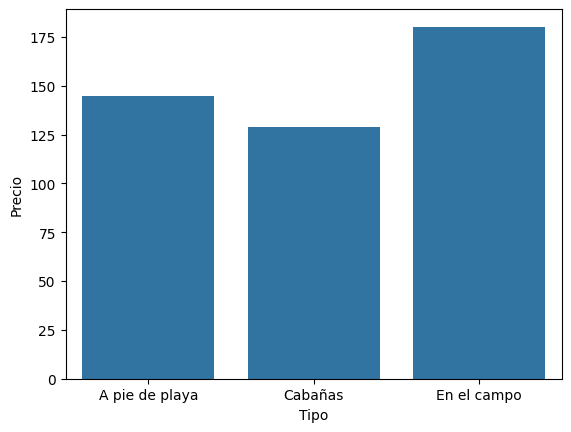

In [26]:
sns.barplot(data=data_apart.groupby('Tipo').agg({
    'Precio':'mean'
}).reset_index(), x='Tipo',y='Precio')


En principio el tipo de apartamento mas caro, son los de tipo en el campo, seguramente debido al mayor espacio que tienen sus propiedades de media.

#### **Relacion entre media de valoraciones y precio**

<Axes: xlabel='Precio', ylabel='Calidad'>

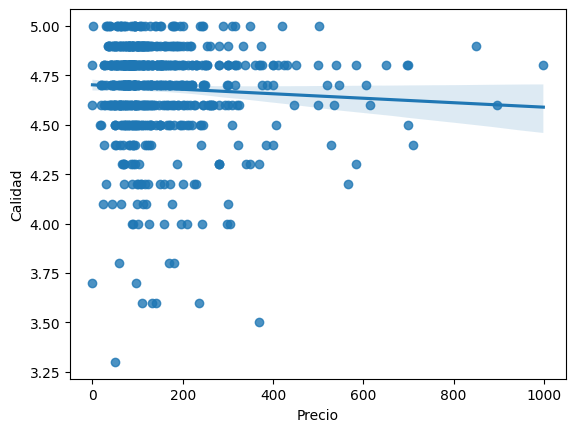

In [31]:
sns.regplot(data=data_apart,x='Precio',y='Calidad')

#### **Relacion entre limpieza y precio**

<Axes: xlabel='Precio', ylabel='Limpieza'>

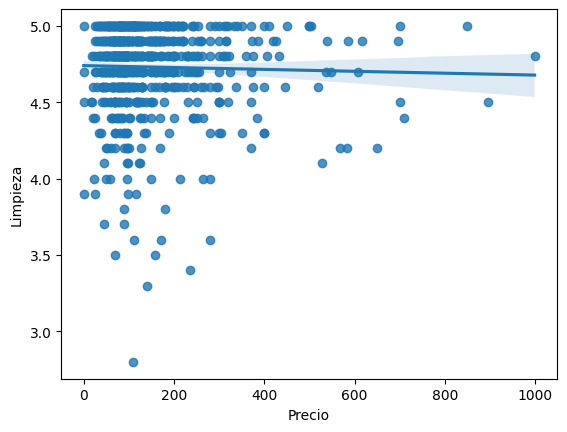

In [30]:
sns.regplot(data=data_apart,x='Precio',y='Limpieza')